In [1]:
# Standard libary imports,
import ast
import random
import string
import pickle

# Third-party libraries,
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# Scikit-learn imports,
from sklearn.ensemble import RandomForestRegressor
import skopt

In [2]:
def test_model(self, X_test, Y_test, plot = True): 

    Y_pred = model.predict(X_test)

    error = []
    for Y_hat, Y in zip(Y_pred, Y_test):
        error.append(abs(Y_hat - Y)/Y)
    error = np.array(error)
    median_error = np.median(error)

    if plot == True:
        hist_bins = np.linspace(start = 0, stop = 1, num = 20)
        plt.hist(error, bins = hist_bins, color = "gray")
        median = np.median(error)
        plt.axvline(x = median_error, color = "red", label = "Median", linestyle = "dashed")
        plt.title("Relative Error of Model")
        plt.xlabel("Relative Error")
        plt.ylabel("Count")
        plt.legend(loc = "upper right", labels = [f"Median: {round(median, 3)}"])
        plt.show()
    
    return median_error

def feature_importance(model, plot = True):

    # Extracting general features and their calculating importance by summing contributions,
    general_features = {}
    for feature_importance, feature_name in zip(model.feature_importances_, feature_names):
        general_feature = feature_name.rsplit("_", 1)[0]

        try:
            general_features[general_feature].append(feature_importance)
        except:
            general_features[general_feature] = []
            general_features[general_feature].append(feature_importance)

    for general_feature in general_features:
        general_features[general_feature] = np.sum(general_features[general_feature])

    # Creating and sorting dataframe,
    general_features = pd.DataFrame(data = {"General Feature": list(general_features.keys()), 
                                            "Importance": list(general_features.values())})
    general_features = general_features.sort_values(by = "Importance", ascending = False)

    # Plotting,
    if plot == True:
        general_features = general_features["General Feature"].to_numpy(), general_features["Importance"].to_numpy()
        plt.bar(general_features[0], general_features[1])
        plt.title("Feature Importance")
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.xticks(rotation = 90)
        plt.show()

    return general_features

## Loading Dataset

In [3]:
X_train = np.genfromtxt("X_train.csv", delimiter = ",")
Y_train = np.genfromtxt("Y_train.csv", delimiter = ",")
X_test = np.genfromtxt("X_test.csv", delimiter = ",")
Y_test = np.genfromtxt("Y_test.csv", delimiter = ",")

# Extracting feature names,
features = dict(ast.literal_eval(open("features.txt", "r").read()))
feature_names = []
for feature in features:
    if len(features[feature]) != 0:
        for unique_value in features[feature]:
            feature_names.append(feature + "_" + unique_value)
    else:
        feature_names.append(feature)

## Random Forest Regressor 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.4s finished


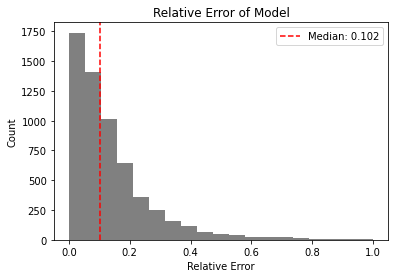

In [4]:
# Training model,
model = RandomForestRegressor(n_estimators = 250, verbose = 1)
model.fit(X_train, Y_train)
test_model(model, X_test, Y_test, plot = True)

# Saving model,
ID = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(5))
model_name = "RandomForestRegressor-" + ID
pickle.dump(model, open(model_name, "wb"))

## Bayesian Hyperparameter Tuning

In [ ]:
model = RandomForestRegressor()

parameter_space = {
    'n_estimators': skopt.space.Integer(250, 500),
    'max_depth': skopt.space.Integer(10, 50),
    'min_samples_split': skopt.space.Real(0.01, 1.0),
    'min_samples_leaf': skopt.space.Real(0.01, 0.5)
}

bayesian_search = skopt.BayesSearchCV(
    model,
    parameter_space,
    n_iter = 25,  # Number of iterations for the search
    scoring = "neg_mean_squared_error",
    n_jobs = -1,  # Use all available CPU cores for parallel optimization
    cv = 5  # Number of cross-validation folds
)

iter_counter = 0
def on_step(optim_result):

    global iter_counter, MSE_list
    iter_counter += 1
    MSE = optim_result.fun

    update_string = f"[Iteration: {iter_counter}, MSE: {MSE}]"
    print(update_string)

# Fitting and testing best model,
bayesian_search.fit(X_train, Y_train, callback = on_step)
model = bayesian_search.best_estimator_
test_model(model, X_test, Y_test, plot = True)

# Saving this model,
ID = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(5))
model_name = "RandomForestRegressor-" + ID
pickle.dump(model, open(model_name, "wb"))

## Load Models

In [ ]:
MODEL_NAME = "RandomForestRegressor-0V0HE"
model = pickle.load(open(MODEL_NAME, "rb"))

## Feature Importance (Node Impurity) 

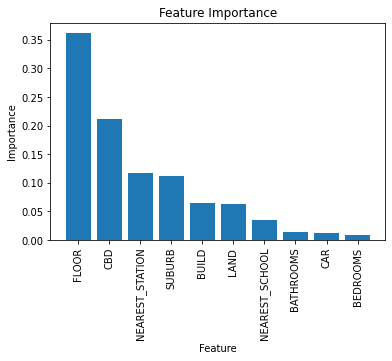

In [5]:
# Summing contributions across features,
general_features = {}
for feature_importance, feature_name in zip(model.feature_importances_, feature_names):
    general_feature = feature_name.rsplit("_", 1)[0]

    try:
        general_features[general_feature].append(feature_importance)
    except:
        general_features[general_feature] = []
        general_features[general_feature].append(feature_importance)

for general_feature in general_features:
    general_features[general_feature] = np.sum(general_features[general_feature])

# Creating and sorting dataframe,
general_features = pd.DataFrame(data = {"General Feature": list(general_features.keys()), 
                                        "Importance": list(general_features.values())})
general_features = general_features.sort_values(by = "Importance", ascending = False)

# Plotting,
general_features = general_features["General Feature"].to_numpy(), general_features["Importance"].to_numpy()
plt.bar(general_features[0], general_features[1])
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation = 90)
plt.show()

## Feature Importance (Shapley Values) 

In [6]:
SAMPLE_SIZE = 100

shap.initjs()
explainer = shap.TreeExplainer(model, X_test)
shap_values = explainer.shap_values(X_test[:SAMPLE_SIZE])
Y_pred = model.predict(X_test[:SAMPLE_SIZE])

 97%|=================== | 97/100 [00:23<00:00]       [Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


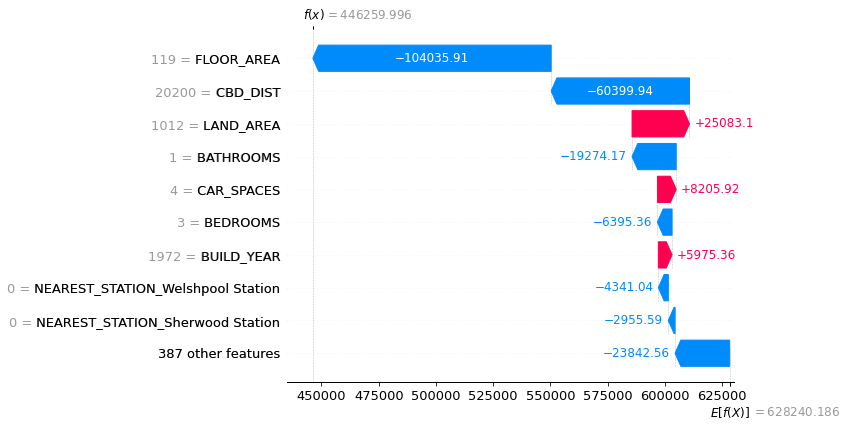

[Prediction: $ 446260.0, Actual: $ 400000.0, Relative Error: 11.6 %]


In [7]:
exp = shap.Explanation(shap_values,
                       explainer.expected_value,
                       data = X_test[:SAMPLE_SIZE],
                       feature_names = feature_names)

idx = 0
shap.plots.waterfall(exp[idx])
print(f"[Prediction: $ {Y_pred[idx]}, Actual: $ {Y_test[idx]}, Relative Error: {round(100*(abs(Y_pred[idx]-Y_test[idx])/Y_test[idx]), 1)} %]")